In [83]:
%matplotlib inline
import torch
from d2l import torch as d2l

class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01, isPlot=True):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

    def forward(self, X):
        return torch.matmul(X, self.w) + self.b

    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2 / 2
        return l.mean()
        
    def configure_optimizers(self):
        return SGD([self.w, self.b], self.lr)

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if self.isPlot:
            self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if self.isPlot:
            self.plot('loss', l, train=False)

class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

1. **What would happen if we were to initialize the weights to zero. Would the algorithm still work? What if we
   initialized the parameters with variance $1000$ rather than $0.01$?**

error in estimating w: tensor([ 0.1408, -0.1860])
error in estimating b: tensor([0.2005])


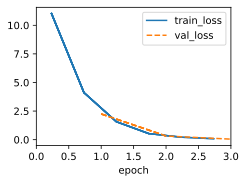

In [84]:
model = LinearRegressionScratch(2, lr=0.03, sigma=0.0)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

The algorithm still work. Because here the loss function is convex and has only one minima, it doesn't matter how the weights are initialized. For more complex networks, the problems will occur: the output will be independent of the input, so the moving direction of the weights at the beginning can't be learned from the input. (my understanding)

There are many answers to it, such as [link](https://stats.stackexchange.com/questions/27112/danger-of-setting-all-initial-weights-to-zero-in-backpropagation)

error in estimating w: tensor([ 67.7144, -80.6186])
error in estimating b: tensor([-5.8025])


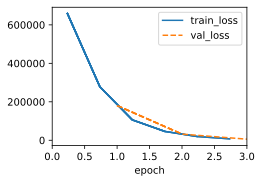

In [85]:
model = LinearRegressionScratch(2, lr=0.03, sigma=1000)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

The estimate error will be very large. If I change the max_epochs to 10:

error in estimating w: tensor([ 0.1640, -0.0192])
error in estimating b: tensor([0.0280])


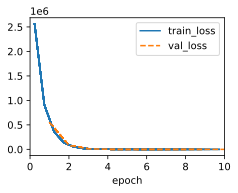

In [86]:
model = LinearRegressionScratch(2, lr=0.03, sigma=1000)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

The error will be much smaller. It is because when the inital parameters are too far away from the optimal solution, we need to iterate more times to get a good estimate.

2. **Assume that you are [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm) trying to come up with a model for resistance that relates voltage and current. Can you use automatic differentiation to learn the parameters of your model?**

The model can be defined as:
$$U = R * I + \epsilon$$
After getting a number of $(U_i,I_i)$, we can estimate R by linear regression. Suppose the actual value of R is 5.

error in estimating b: tensor([0.0460])


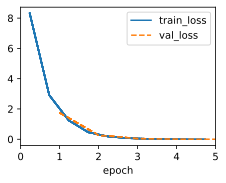

In [89]:
class ohmModel(d2l.Module):  #@save
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.zeros(1, requires_grad=True)

    def forward(self, X):
        return self.w * X

    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2 / 2
        return l.mean()
        
    def configure_optimizers(self):
        return SGD([self.w], self.lr)

model = ohmModel(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([5.0]), b=0)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating b: {data.w - model.w}')

3. **Can you use [Planck's Law](https://en.wikipedia.org/wiki/Planck%27s_law) to determine the temperature of an object using spectral energy density? For reference, the spectral density $B$ of radiation emanating from a black body is
   $B(\lambda, T) = \frac{2 hc^2}{\lambda^5} \cdot \left(\exp \frac{h c}{\lambda k T} - 1\right)^{-1}$. Here
   $\lambda$ is the wavelength, $T$ is the temperature, $c$ is the speed of light, $h$ is Planck's constant, and $k$ is the
   Boltzmann constant. You measure the energy for different wavelengths $\lambda$ and you now need to fit the spectral
   density curve to Planck's law.**

https://pandalab.me/archives/d2l_lr_scratch

tensor([4997.9653], requires_grad=True)

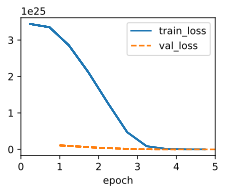

In [90]:
def f(t, x):
    c = 299792458
    h = 6.6260701e-34
    k = 1.380649e-23
    beta = h*c/(k*x)
    alpha = 2*h*c**2/x**5
    return alpha/(torch.exp(beta/t)-1)

class SyntheticPlankData(d2l.DataModule):
    def __init__(self, T, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.arange(300, n) * 1e-9
        noise = torch.randn(n-300) * noise
        self.y = f(T, self.X)+noise
        
    def get_tensorloader(self, tensor, train, indices=slice(0, None)):
        tensor = tuple(a[indices] for a in tensor)
        dataset = torch.utils.data.TensorDataset(*tensor)
        return torch.utils.data.DataLoader(dataset, self.batch_size,
                                           shuffle=train)

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)


class PlankModel(d2l.Module):
    def __init__(self, T, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.T = torch.Tensor([T])
        self.T.requires_grad = True

    def forward(self, X):
        return f(self.T, X)

    def loss(self, y_hat, y):
        l = (y_hat-y)**2/2
        return l.mean()

    def configure_optimizers(self):
        return d2l.SGD([self.T], self.lr)

data = SyntheticPlankData(5000)
model = PlankModel(T=3000, lr=1e-21)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)
model.T

4. **What are the problems you might encounter if you wanted to compute the second derivatives of the loss? How would
   you fix them?**

<font color = red>(uncertain)</font>

We need to use `retain_graph=True` to retain the graph for second derivatives.

In [91]:
import torch

x = torch.tensor([1.0, 2.0], requires_grad=True)
print(x)
y = x**3

dy = torch.autograd.grad(y, x, grad_outputs=torch.ones(x.shape),
                         retain_graph=True, create_graph=True)

print(dy)
dy2 = torch.autograd.grad(dy, x, grad_outputs=torch.ones(x.shape))

print(dy2)

tensor([1., 2.], requires_grad=True)
(tensor([ 3., 12.], grad_fn=<MulBackward0>),)
(tensor([ 6., 12.]),)


For complex network, computing the second derivatives will cost much more time and storage ?

5. **Why is the `reshape` method needed in the `loss` function?**

<font color = red>(uncertain)</font>

As used in the exercises above, it works fine without the reshape method. So under what circumstances will the size of two tensor be different? 

6. **Experiment using different learning rates to find out how quickly the loss function value drops. Can you reduce the
   error by increasing the number of epochs of training?**

Try LR = 0.03, 0.3, 3 

error in estimating w: tensor([ 0.1544, -0.1526])
error in estimating b: tensor([0.2412])


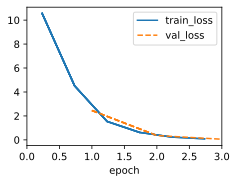

In [92]:
model = LinearRegressionScratch(2, lr=0.03, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([-0.0004,  0.0022])
error in estimating b: tensor([-0.0011])


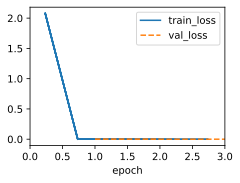

In [93]:
model = LinearRegressionScratch(2, lr=0.3, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([-1.7887e+30, -1.1203e+30])
error in estimating b: tensor([2.8894e+29])


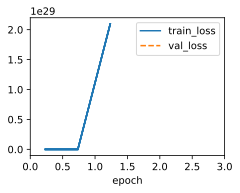

In [94]:
model = LinearRegressionScratch(2, lr=3, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([nan, nan])
error in estimating b: tensor([nan])


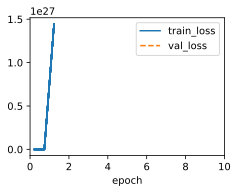

In [95]:
model = LinearRegressionScratch(2, lr=3, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

When the learning rate is too large, we can't reduce the error by increasing the number of epochs. Because the parameters are updated with a large step that make it jump over the optimal solution. For suitbale learning rate, we can reduce the error to a low level.

7. **If the number of examples cannot be divided by the batch size, what happens to `data_iter` at the end of an epoch?**

In [96]:
class Trainer2(d2l.Trainer):  #@save
    def fit_epoch(self):
        self.model.train()
        for batch in self.train_dataloader:
            if batch[0].size()[0] != 32: # print the number of examples when it is not equal to 32
                print(batch[0].size()[0])
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1

model = LinearRegressionScratch(2, lr=0.03, sigma=0.01, isPlot=False)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

8
8
8


`torch.utils.data.DataLoader` has argument `drop_last`. It is set to `False` by default, so the final batch is retained. Since we use 1000 examples here and set the batchsize to 32, the last batch has 8 examples. The program prints 8 three times because we train 3 epochs.

8. **Try implementing a different loss function, such as the absolute value loss `(y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()`.**
    1. Check what happens for regular data.
    1. Check whether there is a difference in behavior if you actively perturb some entries, such as $y_5 = 10000$, of $\mathbf{y}$.
    1. Can you think of a cheap solution for combining the best aspects of squared loss and absolute value loss?
       Hint: how can you avoid really large gradient values?

A. Change to the absolute value loss.

error in estimating w: tensor([ 0.1032, -0.2554])
error in estimating b: tensor([0.1200])


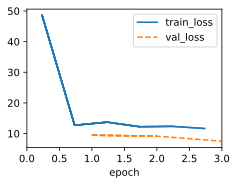

In [97]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()
    return l.mean()

model = LinearRegressionScratch(2, lr=0.03, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

The estimate value is still close to ground-truth. However, the loss can't converge to zero, even when I increase the number of epochs.

error in estimating w: tensor([-0.0291,  0.0498])
error in estimating b: tensor([-0.1800])


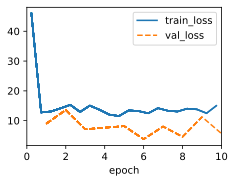

In [98]:
model = LinearRegressionScratch(2, lr=0.03, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

When I decrease the learning rate, the loss decreased.

error in estimating w: tensor([0.0812, 0.1135])
error in estimating b: tensor([-0.0200])


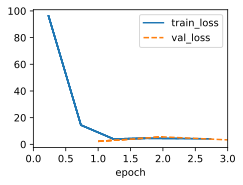

In [99]:
model = LinearRegressionScratch(2, lr=0.01, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

It seems that while using the absolute error loss, the parameters need to be updated at a smaller learning rate. Maybe it's because the loss curve is not smooth and convex.

B. when set $y_5=10000$, the absolute error loss:

error in estimating w: tensor([0.3587, 0.0231])
error in estimating b: tensor([0.1800])


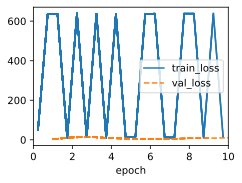

In [100]:
model = LinearRegressionScratch(2, lr=0.03, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
data.y[4] = 10000
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

The squared loss:

error in estimating w: tensor([ 12.0657, -18.2515])
error in estimating b: tensor([-10.6542])


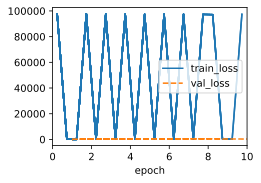

In [101]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

model = LinearRegressionScratch(2, lr=0.03, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
data.y[4] = 10000
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

It can be seen that the estimating error is much larger when using the squared loss. It is because the squared loss is more vulnerable to outliers.

C. We can found that the squared error is strongly convex in aneighborhood of its minimum, but vulnerable to outliers. We can use huber loss to combine them:

![3_4_8](material/3_4_8.png)

This function is quadratic for small values of a, and linear for large values.

9. **Why do we need to reshuffle the dataset? Can you design a case where a maliciously constructed dataset would break the optimization algorithm otherwise?**

Because we want each batch of data to reflect the characteristics of the entire data set. If not, we may encounte clusters of similar examples together in a batch, making the parameters update to the wrong direction. The noise in the first half of the data set is positive and in the second half it is negative.